In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
import os.path as path
import os
os.environ['OMP_NUM_THREADS'] = '2'

import lib.dist as dist
import lib.utils as utils


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update({
    'font.family' : 'STIXGeneral',
    'mathtext.fontset' : 'stix', 
    'xtick.labelsize' : 13,
    'xtick.top' : True,
    'xtick.direction' : 'in',
    'ytick.direction' : 'in',
    'ytick.labelsize' : 13, 
    'ytick.right' : True, 
    'axes.labelsize' : 16,
    'legend.frameon': False,
    'legend.fontsize': 13,
    'legend.handlelength' : 1.5,
    'savefig.dpi' : 300,
    'savefig.bbox' : 'tight'
})
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
torch.__version__

'1.7.1'

In [2]:
b = 60

txt = np.loadtxt(f'../1_QMC/train/Bethe_14_beta{b:d}/field-2.10.dat')
s_num, s_len = txt.shape
print("txt.shape =", s_num, s_len)
s_train = 1000
s_test = 2000
if (s_train+s_test > s_num): print("WARNING : not enough datapoints")
    
beta = 6
prior_dist = dist.Normal()
q_dist = dist.Normal()

txt.shape = 3000 288


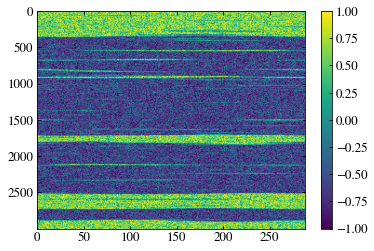

In [24]:
txt = np.loadtxt(f'../3_VAE_recon/test_LR8/Bethe_14_beta{b:d}/field-2.50.dat')
txt = np.loadtxt(f'../1_QMC/train/Bethe_14_beta{b:d}/field-2.50.dat')
plt.imshow(txt, aspect='auto')
cd = plt.colorbar()

In [65]:
U = np.array([0.01*i for i in range(100, 401)])
U_up, U_dn = [], []
for i, u in enumerate(U):
    if path.isfile(f'../1_QMC/train/Bethe_14_beta{b:d}/field-{u:.2f}.dat')==True: U_up.append(u)
    if path.isfile(f'../1_QMC/train/Bethe_41_beta{b:d}/field-{u:.2f}.dat')==True: U_dn.append(u)
U_up = np.array(U_up)
U_dn = np.array(U_dn)
spin2d_up_train = np.zeros((len(U_up)*s_train, s_len))
spin2d_dn_train = np.zeros((len(U_dn)*s_train, s_len))
spin2d_up_test = np.zeros((len(U_up)*s_test, s_len))
spin2d_dn_test = np.zeros((len(U_dn)*s_test, s_len))
spin2d_up = np.zeros((len(U_up)*s_num, s_len))
spin2d_dn = np.zeros((len(U_dn)*s_num, s_len))
print("U_up, U_dn len =", len(U_up), len(U_dn))
print("spin2d_up_train size =", spin2d_up_train.shape[0], spin2d_up_train.shape[1])
print("spin2d_dn_train size =", spin2d_dn_train.shape[0], spin2d_dn_train.shape[1])

for i, u in enumerate(U_up):
    txt = np.loadtxt(f'../1_QMC/train/Bethe_14_beta{b:d}/field-{u:.2f}.dat')
    txt = 0.5*txt + 0.5
    spin2d_up_train[i*s_train:(i+1)*s_train] = txt[:s_train,:]
    spin2d_up_test[i*s_test:(i+1)*s_test] = txt[-s_test:,:]
    spin2d_up[i*s_num:(i+1)*s_num] = txt
for i, u in enumerate(U_dn):
    txt = np.loadtxt(f'../1_QMC/train/Bethe_41_beta{b:d}/field-{u:.2f}.dat')
    txt = 0.5*txt + 0.5
    spin2d_dn_train[i*s_train:(i+1)*s_train] = txt[:s_train,:]
    spin2d_dn_test[i*s_test:(i+1)*s_test] = txt[-s_test:,:]
    spin2d_dn[i*s_num:(i+1)*s_num] = txt


spin2d = np.concatenate([spin2d_up_train, spin2d_dn_train])
spin2d = torch.Tensor(spin2d)
print("spin2d size =", spin2d.size())

U_up, U_dn len = 67 67
spin2d_up_train size = 67000 288
spin2d_dn_train size = 67000 288
spin2d size = torch.Size([134000, 288])


In [4]:
latent_dim = 8
h_node = 100

class NEncoder(nn.Module):
    def __init__(self, output_dim):
        super(NEncoder, self).__init__()
        self.output_dim = output_dim

        self.L1 = nn.Linear(s_len, h_node)
        self.b1 = nn.Linear(h_node, 1, bias=False)
        self.L2 = nn.Linear(h_node, output_dim)
        self.b2 = nn.Linear(output_dim, 1, bias=False)
        self.act = nn.Tanh()
        
        nn.init.xavier_normal_(self.L1.weight)
        nn.init.xavier_normal_(self.L2.weight)
        self.b1.weight.data.fill_(0)
        self.b2.weight.data.fill_(0)

    def forward(self, x):
        h = x.view(-1, s_len)
        h = self.act(self.L1(h)+self.b1.weight)
        h = self.L2(h)+self.b2.weight
        z = self.act(h).view(x.size(0), self.output_dim)
        return z
    
class NDecoder(nn.Module):
    def __init__(self, input_dim):
        super(NDecoder, self).__init__()
        self.L1 = nn.Linear(h_node, s_len)
        self.b1 = nn.Linear(s_len, 1, bias=False)
        self.L2 = nn.Linear(input_dim, h_node)
        self.b2 = nn.Linear(h_node, 1, bias=False)
        self.act = nn.Tanh()
        
        nn.init.xavier_normal_(self.L1.weight)
        nn.init.xavier_normal_(self.L2.weight)
        self.b1.weight.data.fill_(0)
        self.b2.weight.data.fill_(0)

    def forward(self, z):
        h = z.view(z.size(0), z.size(1))
        h = self.act(self.L2(h)+self.b2.weight)
        mu_img = self.act(self.L1(h)+self.b1.weight)
        return mu_img
    
def logsumexp(value, dim=None, keepdim=False):
    """Numerically stable implementation of the operation
    value.exp().sum(dim, keepdim).log()
    """
    if dim is not None:
        m, _ = torch.max(value, dim=dim, keepdim=True)
        value0 = value - m
        if keepdim is False:
            m = m.squeeze(dim)
        return m + torch.log(torch.sum(torch.exp(value0),
                                       dim=dim, keepdim=keepdim))
    else:
        m = torch.max(value)
        sum_exp = torch.sum(torch.exp(value - m))
        if isinstance(sum_exp, Number):
            return m + math.log(sum_exp)
        else:
            return m + torch.log(sum_exp)
    
### beta-TCVAE
class TCVAE(nn.Module):
    def __init__(self, z_dim, beta, prior_dist=dist.Normal(), q_dist=dist.Normal(),
                 include_mutinfo=True, tcvae=True, mss=True):
        super(TCVAE, self).__init__()
        
        self.z_dim = z_dim
        self.include_mutinfo = include_mutinfo
        self.tcvae = tcvae
        self.lamb = 0
        self.beta = beta
        self.mss = mss
        self.x_dist = dist.Bernoulli()

        self.prior_dist = prior_dist
        self.q_dist = q_dist
        self.register_buffer('prior_params', torch.zeros(self.z_dim, 2))

        self.encoder = NEncoder(z_dim * self.q_dist.nparams)
        self.decoder = NDecoder(z_dim)

    def _get_prior_params(self, batch_size=1):
        expanded_size = (batch_size,) + self.prior_params.size()
        prior_params = Variable(self.prior_params.expand(expanded_size))
        return prior_params
    
    def model_sample(self, batch_size=1):
        prior_params = self._get_prior_params(batch_size)
        zs = self.prior_dist.sample(params=prior_params)
        x_params = self.decoder.forward(zs)
        return x_params

    def encode(self, x):
        x = x.view(x.size(0), s_len)
        z_params = self.encoder.forward(x).view(x.size(0), self.z_dim, self.q_dist.nparams)
        zs = self.q_dist.sample(params=z_params)
        return zs, z_params

    def decode(self, z):
        x_params = self.decoder.forward(z).view(z.size(0), s_len)
        xs = self.x_dist.sample(params=x_params)
        return xs, x_params

    def reconstruct_img(self, x):
        zs, z_params = self.encode(x)
        xs, x_params = self.decode(zs)
        return xs, x_params, zs, z_params
    
    def _log_importance_weight_matrix(self, batch_size, dataset_size):
        N = dataset_size
        M = batch_size - 1
        strat_weight = (N - M) / (N * M)
        W = torch.Tensor(batch_size, batch_size).fill_(1 / M)
        W.view(-1)[::M+1] = 1 / N
        W.view(-1)[1::M+1] = strat_weight
        W[M-1, 0] = strat_weight
        return W.log()
    
    def elbo(self, x, dataset_size):
        batch_size = x.size(0) 
        x = x.view(batch_size, s_len)
        prior_params = self._get_prior_params(batch_size)
        x_recon, x_params, zs, z_params = self.reconstruct_img(x)
        logpx = self.x_dist.log_density(x, params=x_params).view(batch_size, -1).sum(1)
        logpz = self.prior_dist.log_density(zs, params=prior_params).view(batch_size, -1).sum(1)
        logqz_condx = self.q_dist.log_density(zs, params=z_params).view(batch_size, -1).sum(1) 

        elbo = logpx + logpz - logqz_condx # log p(x|z) + log p(z) - log q(z|x)
        # log q(z) ~ log 1/(NM) sum_m=1^M q(z|x_m) = - log(MN) + logsumexp_m(q(z|x_m))
        _logqz = self.q_dist.log_density(zs.view(batch_size, 1, self.z_dim),
                                         z_params.view(1, batch_size, self.z_dim, self.q_dist.nparams))

        if not self.mss: # minibatch weighted sampling
            logqz_prodmarginals = (logsumexp(_logqz, dim=1, keepdim=False) - math.log(batch_size * dataset_size)).sum(1)
            logqz = (logsumexp(_logqz.sum(2), dim=1, keepdim=False) - math.log(batch_size * dataset_size))
        else: # minibatch stratified sampling
            logiw_matrix = Variable(self._log_importance_weight_matrix(batch_size, dataset_size).type_as(_logqz.data))
            logqz = logsumexp(logiw_matrix + _logqz.sum(2), dim = 1, keepdim=False)
            logqz_prodmarginals = logsumexp(
                logiw_matrix.view(batch_size, batch_size, 1) + _logqz, dim = 1, keepdim = False).sum(1)

        if self.include_mutinfo:
            elbo2 = logpx - logqz_condx + logqz - self.beta * (logqz - logqz_prodmarginals) - \
                                (1 - self.lamb) * (logqz_prodmarginals - logpz)
        else:
            elbo2 = logpx - self.beta * (logqz - logqz_prodmarginals) - \
                                (1 - self.lamb) * (logqz_prodmarginals - logpz)

        return elbo2, elbo.detach()
    
model_NN100 = TCVAE(z_dim=latent_dim, beta=beta, prior_dist=prior_dist, q_dist=q_dist)
model_NN100.load_state_dict(torch.load('./frozen/VAE_NN100.pth'))

<All keys matched successfully>

In [5]:
latent_dim = 8
h_node = 10

class NEncoder(nn.Module):
    def __init__(self, output_dim):
        super(NEncoder, self).__init__()
        self.output_dim = output_dim

        self.L1 = nn.Linear(s_len, h_node)
        self.b1 = nn.Linear(h_node, 1, bias=False)
        self.L2 = nn.Linear(h_node, output_dim)
        self.b2 = nn.Linear(output_dim, 1, bias=False)
        self.act = nn.Tanh()
        
        nn.init.xavier_normal_(self.L1.weight)
        nn.init.xavier_normal_(self.L2.weight)
        self.b1.weight.data.fill_(0)
        self.b2.weight.data.fill_(0)

    def forward(self, x):
        h = x.view(-1, s_len)
        h = self.act(self.L1(h)+self.b1.weight)
        h = self.L2(h)+self.b2.weight
        z = self.act(h).view(x.size(0), self.output_dim)
        return z
    
class NDecoder(nn.Module):
    def __init__(self, input_dim):
        super(NDecoder, self).__init__()
        self.L1 = nn.Linear(h_node, s_len)
        self.b1 = nn.Linear(s_len, 1, bias=False)
        self.L2 = nn.Linear(input_dim, h_node)
        self.b2 = nn.Linear(h_node, 1, bias=False)
        self.act = nn.Tanh()
        
        nn.init.xavier_normal_(self.L1.weight)
        nn.init.xavier_normal_(self.L2.weight)
        self.b1.weight.data.fill_(0)
        self.b2.weight.data.fill_(0)

    def forward(self, z):
        h = z.view(z.size(0), z.size(1))
        h = self.act(self.L2(h)+self.b2.weight)
        mu_img = self.act(self.L1(h)+self.b1.weight)
        return mu_img
    
def logsumexp(value, dim=None, keepdim=False):
    """Numerically stable implementation of the operation
    value.exp().sum(dim, keepdim).log()
    """
    if dim is not None:
        m, _ = torch.max(value, dim=dim, keepdim=True)
        value0 = value - m
        if keepdim is False:
            m = m.squeeze(dim)
        return m + torch.log(torch.sum(torch.exp(value0),
                                       dim=dim, keepdim=keepdim))
    else:
        m = torch.max(value)
        sum_exp = torch.sum(torch.exp(value - m))
        if isinstance(sum_exp, Number):
            return m + math.log(sum_exp)
        else:
            return m + torch.log(sum_exp)
    
### beta-TCVAE
class TCVAE(nn.Module):
    def __init__(self, z_dim, beta, prior_dist=dist.Normal(), q_dist=dist.Normal(),
                 include_mutinfo=True, tcvae=True, mss=True):
        super(TCVAE, self).__init__()
        
        self.z_dim = z_dim
        self.include_mutinfo = include_mutinfo
        self.tcvae = tcvae
        self.lamb = 0
        self.beta = beta
        self.mss = mss
        self.x_dist = dist.Bernoulli()

        self.prior_dist = prior_dist
        self.q_dist = q_dist
        self.register_buffer('prior_params', torch.zeros(self.z_dim, 2))

        self.encoder = NEncoder(z_dim * self.q_dist.nparams)
        self.decoder = NDecoder(z_dim)

    def _get_prior_params(self, batch_size=1):
        expanded_size = (batch_size,) + self.prior_params.size()
        prior_params = Variable(self.prior_params.expand(expanded_size))
        return prior_params
    
    def model_sample(self, batch_size=1):
        prior_params = self._get_prior_params(batch_size)
        zs = self.prior_dist.sample(params=prior_params)
        x_params = self.decoder.forward(zs)
        return x_params

    def encode(self, x):
        x = x.view(x.size(0), s_len)
        z_params = self.encoder.forward(x).view(x.size(0), self.z_dim, self.q_dist.nparams)
        zs = self.q_dist.sample(params=z_params)
        return zs, z_params

    def decode(self, z):
        x_params = self.decoder.forward(z).view(z.size(0), s_len)
        xs = self.x_dist.sample(params=x_params)
        return xs, x_params

    def reconstruct_img(self, x):
        zs, z_params = self.encode(x)
        xs, x_params = self.decode(zs)
        return xs, x_params, zs, z_params
    
    def _log_importance_weight_matrix(self, batch_size, dataset_size):
        N = dataset_size
        M = batch_size - 1
        strat_weight = (N - M) / (N * M)
        W = torch.Tensor(batch_size, batch_size).fill_(1 / M)
        W.view(-1)[::M+1] = 1 / N
        W.view(-1)[1::M+1] = strat_weight
        W[M-1, 0] = strat_weight
        return W.log()
    
    def elbo(self, x, dataset_size):
        batch_size = x.size(0) 
        x = x.view(batch_size, s_len)
        prior_params = self._get_prior_params(batch_size)
        x_recon, x_params, zs, z_params = self.reconstruct_img(x)
        logpx = self.x_dist.log_density(x, params=x_params).view(batch_size, -1).sum(1)
        logpz = self.prior_dist.log_density(zs, params=prior_params).view(batch_size, -1).sum(1)
        logqz_condx = self.q_dist.log_density(zs, params=z_params).view(batch_size, -1).sum(1) 

        elbo = logpx + logpz - logqz_condx # log p(x|z) + log p(z) - log q(z|x)
        # log q(z) ~ log 1/(NM) sum_m=1^M q(z|x_m) = - log(MN) + logsumexp_m(q(z|x_m))
        _logqz = self.q_dist.log_density(zs.view(batch_size, 1, self.z_dim),
                                         z_params.view(1, batch_size, self.z_dim, self.q_dist.nparams))

        if not self.mss: # minibatch weighted sampling
            logqz_prodmarginals = (logsumexp(_logqz, dim=1, keepdim=False) - math.log(batch_size * dataset_size)).sum(1)
            logqz = (logsumexp(_logqz.sum(2), dim=1, keepdim=False) - math.log(batch_size * dataset_size))
        else: # minibatch stratified sampling
            logiw_matrix = Variable(self._log_importance_weight_matrix(batch_size, dataset_size).type_as(_logqz.data))
            logqz = logsumexp(logiw_matrix + _logqz.sum(2), dim = 1, keepdim=False)
            logqz_prodmarginals = logsumexp(
                logiw_matrix.view(batch_size, batch_size, 1) + _logqz, dim = 1, keepdim = False).sum(1)

        if self.include_mutinfo:
            elbo2 = logpx - logqz_condx + logqz - self.beta * (logqz - logqz_prodmarginals) - \
                                (1 - self.lamb) * (logqz_prodmarginals - logpz)
        else:
            elbo2 = logpx - self.beta * (logqz - logqz_prodmarginals) - \
                                (1 - self.lamb) * (logqz_prodmarginals - logpz)

        return elbo2, elbo.detach()
    
model_NN10 = TCVAE(z_dim=latent_dim, beta=beta, prior_dist=prior_dist, q_dist=q_dist)
model_NN10.load_state_dict(torch.load('./frozen/VAE_NN10.pth'))


<All keys matched successfully>

In [6]:
latent_dim = 8
class NEncoder(nn.Module):
    def __init__(self, output_dim):
        super(NEncoder, self).__init__()
        self.output_dim = output_dim

        self.L1 = nn.Linear(s_len, output_dim)
        self.b1 = nn.Linear(output_dim, 1, bias=False)

        self.act = nn.Tanh()
        
        nn.init.xavier_normal_(self.L1.weight)
        self.b1.weight.data.fill_(0)

    def forward(self, x):
        h = x.view(-1, s_len)
        z = (self.act(self.L1(h)+self.b1.weight)).view(x.size(0), self.output_dim)
        return z
    
class NDecoder(nn.Module):
    def __init__(self, input_dim):
        super(NDecoder, self).__init__()
        self.L1 = nn.Linear(input_dim, s_len)
        self.b1 = nn.Linear(s_len, 1, bias=False)

        self.act = nn.Tanh()
        
        nn.init.xavier_normal_(self.L1.weight)
        self.b1.weight.data.fill_(0)

    def forward(self, z):
        h = z.view(z.size(0), z.size(1))
        mu_img = self.act(self.L1(h)+self.b1.weight)
        return mu_img
    
def logsumexp(value, dim=None, keepdim=False):
    """Numerically stable implementation of the operation
    value.exp().sum(dim, keepdim).log()
    """
    if dim is not None:
        m, _ = torch.max(value, dim=dim, keepdim=True)
        value0 = value - m
        if keepdim is False:
            m = m.squeeze(dim)
        return m + torch.log(torch.sum(torch.exp(value0),
                                       dim=dim, keepdim=keepdim))
    else:
        m = torch.max(value)
        sum_exp = torch.sum(torch.exp(value - m))
        if isinstance(sum_exp, Number):
            return m + math.log(sum_exp)
        else:
            return m + torch.log(sum_exp)
        
### beta-TCVAE
class TCVAE(nn.Module):
    def __init__(self, z_dim, beta, prior_dist=dist.Normal(), q_dist=dist.Normal(),
                 include_mutinfo=True, tcvae=True, mss=True):
        super(TCVAE, self).__init__()
        
        self.z_dim = z_dim
        self.include_mutinfo = include_mutinfo
        self.tcvae = tcvae
        self.lamb = 0
        self.beta = beta
        self.mss = mss
        self.x_dist = dist.Bernoulli()

        self.prior_dist = prior_dist
        self.q_dist = q_dist
        self.register_buffer('prior_params', torch.zeros(self.z_dim, 2))

        self.encoder = NEncoder(z_dim * self.q_dist.nparams)
        self.decoder = NDecoder(z_dim)

    def _get_prior_params(self, batch_size=1):
        expanded_size = (batch_size,) + self.prior_params.size()
        prior_params = Variable(self.prior_params.expand(expanded_size))
        return prior_params
    
    def model_sample(self, batch_size=1):
        prior_params = self._get_prior_params(batch_size)
        zs = self.prior_dist.sample(params=prior_params)
        x_params = self.decoder.forward(zs)
        return x_params

    def encode(self, x):
        x = x.view(x.size(0), s_len)
        z_params = self.encoder.forward(x).view(x.size(0), self.z_dim, self.q_dist.nparams)
        zs = self.q_dist.sample(params=z_params)
        return zs, z_params

    def decode(self, z):
        x_params = self.decoder.forward(z).view(z.size(0), s_len)
        xs = self.x_dist.sample(params=x_params)
        return xs, x_params

    def reconstruct_img(self, x):
        zs, z_params = self.encode(x)
        xs, x_params = self.decode(zs)
        return xs, x_params, zs, z_params
    
    def _log_importance_weight_matrix(self, batch_size, dataset_size):
        N = dataset_size
        M = batch_size - 1
        strat_weight = (N - M) / (N * M)
        W = torch.Tensor(batch_size, batch_size).fill_(1 / M)
        W.view(-1)[::M+1] = 1 / N
        W.view(-1)[1::M+1] = strat_weight
        W[M-1, 0] = strat_weight
        return W.log()
    
    def elbo(self, x, dataset_size):
        batch_size = x.size(0) 
        x = x.view(batch_size, s_len)
        prior_params = self._get_prior_params(batch_size)
        x_recon, x_params, zs, z_params = self.reconstruct_img(x)
        logpx = self.x_dist.log_density(x, params=x_params).view(batch_size, -1).sum(1)
        logpz = self.prior_dist.log_density(zs, params=prior_params).view(batch_size, -1).sum(1)
        logqz_condx = self.q_dist.log_density(zs, params=z_params).view(batch_size, -1).sum(1) 

        elbo = logpx + logpz - logqz_condx # log p(x|z) + log p(z) - log q(z|x)
        # log q(z) ~ log 1/(NM) sum_m=1^M q(z|x_m) = - log(MN) + logsumexp_m(q(z|x_m))
        _logqz = self.q_dist.log_density(zs.view(batch_size, 1, self.z_dim),
                                         z_params.view(1, batch_size, self.z_dim, self.q_dist.nparams))

        if not self.mss: # minibatch weighted sampling
            logqz_prodmarginals = (logsumexp(_logqz, dim=1, keepdim=False) - math.log(batch_size * dataset_size)).sum(1)
            logqz = (logsumexp(_logqz.sum(2), dim=1, keepdim=False) - math.log(batch_size * dataset_size))
        else: # minibatch stratified sampling
            logiw_matrix = Variable(self._log_importance_weight_matrix(batch_size, dataset_size).type_as(_logqz.data))
            logqz = logsumexp(logiw_matrix + _logqz.sum(2), dim = 1, keepdim=False)
            logqz_prodmarginals = logsumexp(
                logiw_matrix.view(batch_size, batch_size, 1) + _logqz, dim = 1, keepdim = False).sum(1)

        if self.include_mutinfo:
            elbo2 = logpx - logqz_condx + logqz - self.beta * (logqz - logqz_prodmarginals) - \
                                (1 - self.lamb) * (logqz_prodmarginals - logpz)
        else:
            elbo2 = logpx - self.beta * (logqz - logqz_prodmarginals) - \
                                (1 - self.lamb) * (logqz_prodmarginals - logpz)

        return elbo2, elbo.detach()

model_LR8 = TCVAE(z_dim=latent_dim, beta=beta, prior_dist=prior_dist, q_dist=q_dist)
model_LR8.load_state_dict(torch.load('./frozen/VAE_LR8.pth'))


<All keys matched successfully>

In [7]:
latent_dim = 4
class NEncoder(nn.Module):
    def __init__(self, output_dim):
        super(NEncoder, self).__init__()
        self.output_dim = output_dim

        self.L1 = nn.Linear(s_len, output_dim)
        self.b1 = nn.Linear(output_dim, 1, bias=False)

        self.act = nn.Tanh()
        
        nn.init.xavier_normal_(self.L1.weight)
        self.b1.weight.data.fill_(0)

    def forward(self, x):
        h = x.view(-1, s_len)
        z = (self.act(self.L1(h)+self.b1.weight)).view(x.size(0), self.output_dim)
        return z
    
class NDecoder(nn.Module):
    def __init__(self, input_dim):
        super(NDecoder, self).__init__()
        self.L1 = nn.Linear(input_dim, s_len)
        self.b1 = nn.Linear(s_len, 1, bias=False)

        self.act = nn.Tanh()
        
        nn.init.xavier_normal_(self.L1.weight)
        self.b1.weight.data.fill_(0)

    def forward(self, z):
        h = z.view(z.size(0), z.size(1))
        mu_img = self.act(self.L1(h)+self.b1.weight)
        return mu_img
    
def logsumexp(value, dim=None, keepdim=False):
    """Numerically stable implementation of the operation
    value.exp().sum(dim, keepdim).log()
    """
    if dim is not None:
        m, _ = torch.max(value, dim=dim, keepdim=True)
        value0 = value - m
        if keepdim is False:
            m = m.squeeze(dim)
        return m + torch.log(torch.sum(torch.exp(value0),
                                       dim=dim, keepdim=keepdim))
    else:
        m = torch.max(value)
        sum_exp = torch.sum(torch.exp(value - m))
        if isinstance(sum_exp, Number):
            return m + math.log(sum_exp)
        else:
            return m + torch.log(sum_exp)
        
### beta-TCVAE
class TCVAE(nn.Module):
    def __init__(self, z_dim, beta, prior_dist=dist.Normal(), q_dist=dist.Normal(),
                 include_mutinfo=True, tcvae=True, mss=True):
        super(TCVAE, self).__init__()
        
        self.z_dim = z_dim
        self.include_mutinfo = include_mutinfo
        self.tcvae = tcvae
        self.lamb = 0
        self.beta = beta
        self.mss = mss
        self.x_dist = dist.Bernoulli()

        self.prior_dist = prior_dist
        self.q_dist = q_dist
        self.register_buffer('prior_params', torch.zeros(self.z_dim, 2))

        self.encoder = NEncoder(z_dim * self.q_dist.nparams)
        self.decoder = NDecoder(z_dim)

    def _get_prior_params(self, batch_size=1):
        expanded_size = (batch_size,) + self.prior_params.size()
        prior_params = Variable(self.prior_params.expand(expanded_size))
        return prior_params
    
    def model_sample(self, batch_size=1):
        prior_params = self._get_prior_params(batch_size)
        zs = self.prior_dist.sample(params=prior_params)
        x_params = self.decoder.forward(zs)
        return x_params

    def encode(self, x):
        x = x.view(x.size(0), s_len)
        z_params = self.encoder.forward(x).view(x.size(0), self.z_dim, self.q_dist.nparams)
        zs = self.q_dist.sample(params=z_params)
        return zs, z_params

    def decode(self, z):
        x_params = self.decoder.forward(z).view(z.size(0), s_len)
        xs = self.x_dist.sample(params=x_params)
        return xs, x_params

    def reconstruct_img(self, x):
        zs, z_params = self.encode(x)
        xs, x_params = self.decode(zs)
        return xs, x_params, zs, z_params
    
    def _log_importance_weight_matrix(self, batch_size, dataset_size):
        N = dataset_size
        M = batch_size - 1
        strat_weight = (N - M) / (N * M)
        W = torch.Tensor(batch_size, batch_size).fill_(1 / M)
        W.view(-1)[::M+1] = 1 / N
        W.view(-1)[1::M+1] = strat_weight
        W[M-1, 0] = strat_weight
        return W.log()
    
    def elbo(self, x, dataset_size):
        batch_size = x.size(0) 
        x = x.view(batch_size, s_len)
        prior_params = self._get_prior_params(batch_size)
        x_recon, x_params, zs, z_params = self.reconstruct_img(x)
        logpx = self.x_dist.log_density(x, params=x_params).view(batch_size, -1).sum(1)
        logpz = self.prior_dist.log_density(zs, params=prior_params).view(batch_size, -1).sum(1)
        logqz_condx = self.q_dist.log_density(zs, params=z_params).view(batch_size, -1).sum(1) 

        elbo = logpx + logpz - logqz_condx # log p(x|z) + log p(z) - log q(z|x)
        # log q(z) ~ log 1/(NM) sum_m=1^M q(z|x_m) = - log(MN) + logsumexp_m(q(z|x_m))
        _logqz = self.q_dist.log_density(zs.view(batch_size, 1, self.z_dim),
                                         z_params.view(1, batch_size, self.z_dim, self.q_dist.nparams))

        if not self.mss: # minibatch weighted sampling
            logqz_prodmarginals = (logsumexp(_logqz, dim=1, keepdim=False) - math.log(batch_size * dataset_size)).sum(1)
            logqz = (logsumexp(_logqz.sum(2), dim=1, keepdim=False) - math.log(batch_size * dataset_size))
        else: # minibatch stratified sampling
            logiw_matrix = Variable(self._log_importance_weight_matrix(batch_size, dataset_size).type_as(_logqz.data))
            logqz = logsumexp(logiw_matrix + _logqz.sum(2), dim = 1, keepdim=False)
            logqz_prodmarginals = logsumexp(
                logiw_matrix.view(batch_size, batch_size, 1) + _logqz, dim = 1, keepdim = False).sum(1)

        if self.include_mutinfo:
            elbo2 = logpx - logqz_condx + logqz - self.beta * (logqz - logqz_prodmarginals) - \
                                (1 - self.lamb) * (logqz_prodmarginals - logpz)
        else:
            elbo2 = logpx - self.beta * (logqz - logqz_prodmarginals) - \
                                (1 - self.lamb) * (logqz_prodmarginals - logpz)

        return elbo2, elbo.detach()

model_LR4 = TCVAE(z_dim=latent_dim, beta=beta, prior_dist=prior_dist, q_dist=q_dist)
model_LR4.load_state_dict(torch.load('./frozen/VAE_LR4.pth'))


<All keys matched successfully>

In [8]:
latent_dim = 2
class NEncoder(nn.Module):
    def __init__(self, output_dim):
        super(NEncoder, self).__init__()
        self.output_dim = output_dim

        self.L1 = nn.Linear(s_len, output_dim)
        self.b1 = nn.Linear(output_dim, 1, bias=False)

        self.act = nn.Tanh()
        
        nn.init.xavier_normal_(self.L1.weight)
        self.b1.weight.data.fill_(0)

    def forward(self, x):
        h = x.view(-1, s_len)
        z = (self.act(self.L1(h)+self.b1.weight)).view(x.size(0), self.output_dim)
        return z
    
class NDecoder(nn.Module):
    def __init__(self, input_dim):
        super(NDecoder, self).__init__()
        self.L1 = nn.Linear(input_dim, s_len)
        self.b1 = nn.Linear(s_len, 1, bias=False)

        self.act = nn.Tanh()
        
        nn.init.xavier_normal_(self.L1.weight)
        self.b1.weight.data.fill_(0)

    def forward(self, z):
        h = z.view(z.size(0), z.size(1))
        mu_img = self.act(self.L1(h)+self.b1.weight)
        return mu_img
    
def logsumexp(value, dim=None, keepdim=False):
    """Numerically stable implementation of the operation
    value.exp().sum(dim, keepdim).log()
    """
    if dim is not None:
        m, _ = torch.max(value, dim=dim, keepdim=True)
        value0 = value - m
        if keepdim is False:
            m = m.squeeze(dim)
        return m + torch.log(torch.sum(torch.exp(value0),
                                       dim=dim, keepdim=keepdim))
    else:
        m = torch.max(value)
        sum_exp = torch.sum(torch.exp(value - m))
        if isinstance(sum_exp, Number):
            return m + math.log(sum_exp)
        else:
            return m + torch.log(sum_exp)
        
### beta-TCVAE
class TCVAE(nn.Module):
    def __init__(self, z_dim, beta, prior_dist=dist.Normal(), q_dist=dist.Normal(),
                 include_mutinfo=True, tcvae=True, mss=True):
        super(TCVAE, self).__init__()
        
        self.z_dim = z_dim
        self.include_mutinfo = include_mutinfo
        self.tcvae = tcvae
        self.lamb = 0
        self.beta = beta
        self.mss = mss
        self.x_dist = dist.Bernoulli()

        self.prior_dist = prior_dist
        self.q_dist = q_dist
        self.register_buffer('prior_params', torch.zeros(self.z_dim, 2))

        self.encoder = NEncoder(z_dim * self.q_dist.nparams)
        self.decoder = NDecoder(z_dim)

    def _get_prior_params(self, batch_size=1):
        expanded_size = (batch_size,) + self.prior_params.size()
        prior_params = Variable(self.prior_params.expand(expanded_size))
        return prior_params
    
    def model_sample(self, batch_size=1):
        prior_params = self._get_prior_params(batch_size)
        zs = self.prior_dist.sample(params=prior_params)
        x_params = self.decoder.forward(zs)
        return x_params

    def encode(self, x):
        x = x.view(x.size(0), s_len)
        z_params = self.encoder.forward(x).view(x.size(0), self.z_dim, self.q_dist.nparams)
        zs = self.q_dist.sample(params=z_params)
        return zs, z_params

    def decode(self, z):
        x_params = self.decoder.forward(z).view(z.size(0), s_len)
        xs = self.x_dist.sample(params=x_params)
        return xs, x_params

    def reconstruct_img(self, x):
        zs, z_params = self.encode(x)
        xs, x_params = self.decode(zs)
        return xs, x_params, zs, z_params
    
    def _log_importance_weight_matrix(self, batch_size, dataset_size):
        N = dataset_size
        M = batch_size - 1
        strat_weight = (N - M) / (N * M)
        W = torch.Tensor(batch_size, batch_size).fill_(1 / M)
        W.view(-1)[::M+1] = 1 / N
        W.view(-1)[1::M+1] = strat_weight
        W[M-1, 0] = strat_weight
        return W.log()
    
    def elbo(self, x, dataset_size):
        batch_size = x.size(0) 
        x = x.view(batch_size, s_len)
        prior_params = self._get_prior_params(batch_size)
        x_recon, x_params, zs, z_params = self.reconstruct_img(x)
        logpx = self.x_dist.log_density(x, params=x_params).view(batch_size, -1).sum(1)
        logpz = self.prior_dist.log_density(zs, params=prior_params).view(batch_size, -1).sum(1)
        logqz_condx = self.q_dist.log_density(zs, params=z_params).view(batch_size, -1).sum(1) 

        elbo = logpx + logpz - logqz_condx # log p(x|z) + log p(z) - log q(z|x)
        # log q(z) ~ log 1/(NM) sum_m=1^M q(z|x_m) = - log(MN) + logsumexp_m(q(z|x_m))
        _logqz = self.q_dist.log_density(zs.view(batch_size, 1, self.z_dim),
                                         z_params.view(1, batch_size, self.z_dim, self.q_dist.nparams))

        if not self.mss: # minibatch weighted sampling
            logqz_prodmarginals = (logsumexp(_logqz, dim=1, keepdim=False) - math.log(batch_size * dataset_size)).sum(1)
            logqz = (logsumexp(_logqz.sum(2), dim=1, keepdim=False) - math.log(batch_size * dataset_size))
        else: # minibatch stratified sampling
            logiw_matrix = Variable(self._log_importance_weight_matrix(batch_size, dataset_size).type_as(_logqz.data))
            logqz = logsumexp(logiw_matrix + _logqz.sum(2), dim = 1, keepdim=False)
            logqz_prodmarginals = logsumexp(
                logiw_matrix.view(batch_size, batch_size, 1) + _logqz, dim = 1, keepdim = False).sum(1)

        if self.include_mutinfo:
            elbo2 = logpx - logqz_condx + logqz - self.beta * (logqz - logqz_prodmarginals) - \
                                (1 - self.lamb) * (logqz_prodmarginals - logpz)
        else:
            elbo2 = logpx - self.beta * (logqz - logqz_prodmarginals) - \
                                (1 - self.lamb) * (logqz_prodmarginals - logpz)

        return elbo2, elbo.detach()

model_LR2 = TCVAE(z_dim=latent_dim, beta=beta, prior_dist=prior_dist, q_dist=q_dist)
model_LR2.load_state_dict(torch.load('./frozen/VAE_LR2.pth'))


<All keys matched successfully>

In [9]:
model_NN100.encoder.L1.weight.data.max(), model_NN100.encoder.L1.weight.data.min(), \
model_NN100.decoder.L1.weight.data.max(), model_NN100.decoder.L1.weight.data.min(),\
model_NN100.encoder.L2.weight.data.max(), model_NN100.encoder.L2.weight.data.min(), \
model_NN100.decoder.L2.weight.data.max(), model_NN100.decoder.L2.weight.data.min()

(tensor(2.4779),
 tensor(-2.5514),
 tensor(6.5368),
 tensor(-6.5393),
 tensor(1.5673),
 tensor(-1.8619),
 tensor(5.5431),
 tensor(-5.5356))

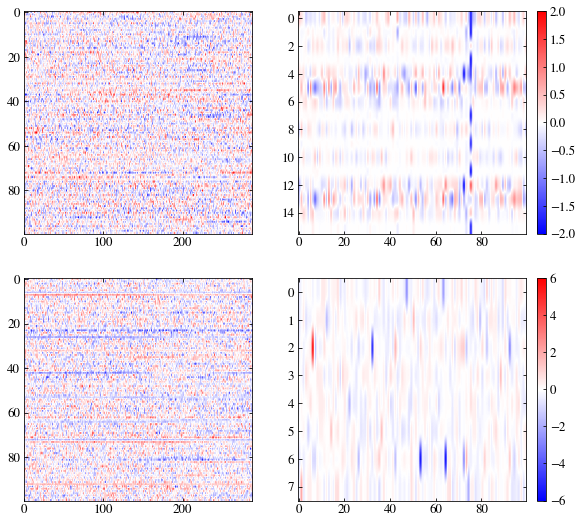

In [10]:
fig, ax = plt.subplots(2,2, figsize = (9, 9))

im00 = ax[0,0].imshow(model_NN100.encoder.L1.weight.data, cmap='bwr', aspect='auto', **{'vmin':-2, 'vmax':2})
im01 = ax[0,1].imshow(model_NN100.encoder.L2.weight.data, cmap='bwr', aspect='auto', **{'vmin':-2, 'vmax':2})
im10 = ax[1,0].imshow(model_NN100.decoder.L1.weight.data.T, cmap='bwr', aspect='auto', **{'vmin':-6, 'vmax':6})
im11 = ax[1,1].imshow(model_NN100.decoder.L2.weight.data.T, cmap='bwr', aspect='auto', **{'vmin':-6, 'vmax':6})

ca0 = inset_axes(ax[0,1], width="5%", height="100%", loc='center left',
                   bbox_to_anchor=(1.05, 0., 0.8, 1), bbox_transform=ax[0,1].transAxes, borderpad=0)
ca1 = inset_axes(ax[1,1], width="5%", height="100%", loc='center left',
                   bbox_to_anchor=(1.05, 0., 0.8, 1), bbox_transform=ax[1,1].transAxes, borderpad=0)
cd = plt.colorbar(im01, cax=ca0)
cd = plt.colorbar(im11, cax=ca1)
plt.savefig('fig/NN100_weight.png')

In [11]:
model_NN10.encoder.L1.weight.data.max(), model_NN10.encoder.L1.weight.data.min(), \
model_NN10.decoder.L1.weight.data.max(), model_NN10.decoder.L1.weight.data.min(),\
model_NN10.encoder.L2.weight.data.max(), model_NN10.encoder.L2.weight.data.min(), \
model_NN10.decoder.L2.weight.data.max(), model_NN10.decoder.L2.weight.data.min()

(tensor(3.0652),
 tensor(-2.8134),
 tensor(1.9575),
 tensor(-1.6209),
 tensor(2.9859),
 tensor(-4.0485),
 tensor(5.9119),
 tensor(-5.7886))

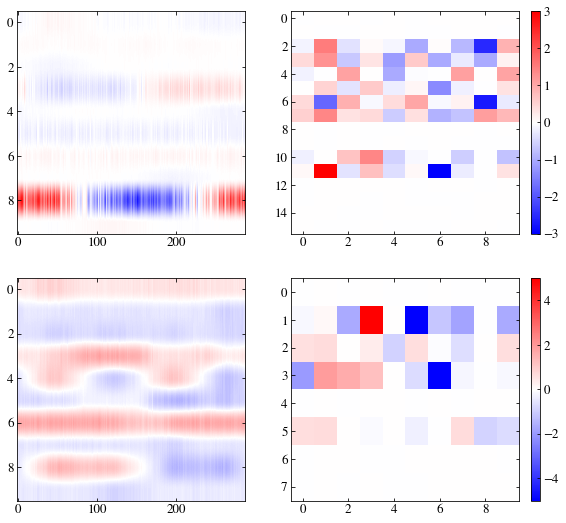

In [12]:
fig, ax = plt.subplots(2,2, figsize = (9, 9))

im00 = ax[0,0].imshow(model_NN10.encoder.L1.weight.data, cmap='bwr', aspect='auto', **{'vmin':-3, 'vmax':3})
im01 = ax[0,1].imshow(model_NN10.encoder.L2.weight.data, cmap='bwr', aspect='auto', **{'vmin':-3, 'vmax':3})
im10 = ax[1,0].imshow(model_NN10.decoder.L1.weight.data.T, cmap='bwr', aspect='auto', **{'vmin':-5, 'vmax':5})
im11 = ax[1,1].imshow(model_NN10.decoder.L2.weight.data.T, cmap='bwr', aspect='auto', **{'vmin':-5, 'vmax':5})

ca0 = inset_axes(ax[0,1], width="5%", height="100%", loc='center left',
                   bbox_to_anchor=(1.05, 0., 0.8, 1), bbox_transform=ax[0,1].transAxes, borderpad=0)
ca1 = inset_axes(ax[1,1], width="5%", height="100%", loc='center left',
                   bbox_to_anchor=(1.05, 0., 0.8, 1), bbox_transform=ax[1,1].transAxes, borderpad=0)
cd = plt.colorbar(im01, cax=ca0)
cd = plt.colorbar(im11, cax=ca1)
plt.savefig('fig/NN10_weight.png')

In [13]:
model_LR8.encoder.L1.weight.data.max(), model_LR8.encoder.L1.weight.data.min(), \
model_LR8.decoder.L1.weight.data.max(), model_LR8.decoder.L1.weight.data.min()

(tensor(0.1110), tensor(-0.1718), tensor(3.1265), tensor(-1.2024))

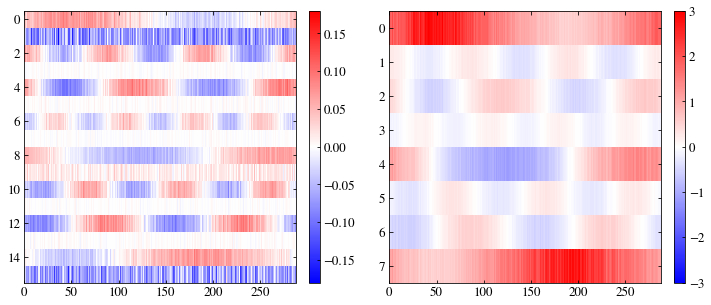

In [14]:
fig, ax = plt.subplots(1,2, figsize = (12, 5))

im0 = ax[0].imshow(model_LR8.encoder.L1.weight.data, interpolation='none', cmap='bwr', aspect=288/16,\
            **{'vmin':-0.18, 'vmax':0.18})
im1 = ax[1].imshow(model_LR8.decoder.L1.weight.data.T, interpolation='none', cmap='bwr', aspect=288/8,\
            **{'vmin':-3, 'vmax':3})

ca0 = inset_axes(ax[0], width="5%", height="100%", loc='center left',
                   bbox_to_anchor=(1.05, 0., 0.8, 1), bbox_transform=ax[0].transAxes, borderpad=0)
ca1 = inset_axes(ax[1], width="5%", height="100%", loc='center left',
                   bbox_to_anchor=(1.05, 0., 0.8, 1), bbox_transform=ax[1].transAxes, borderpad=0)
cd = plt.colorbar(im0, cax=ca0)
cd = plt.colorbar(im1, cax=ca1)

plt.savefig('fig/LR8_weight.png')

In [15]:
model_LR4.encoder.L1.weight.data.max(), model_LR4.encoder.L1.weight.data.min(), \
model_LR4.decoder.L1.weight.data.max(), model_LR4.decoder.L1.weight.data.min()

(tensor(0.0966), tensor(-0.1525), tensor(2.9864), tensor(-1.1451))

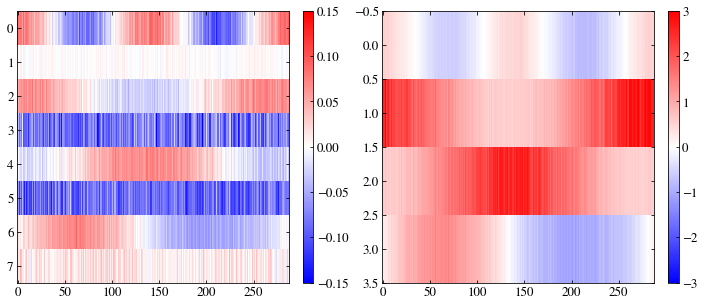

In [16]:
fig, ax = plt.subplots(1,2, figsize = (12, 5))

im0 = ax[0].imshow(model_LR4.encoder.L1.weight.data, interpolation='none', cmap='bwr', aspect=288/8,\
            **{'vmin':-0.15, 'vmax':0.15})
im1 = ax[1].imshow(model_LR4.decoder.L1.weight.data.T, interpolation='none', cmap='bwr', aspect=288/4,\
            **{'vmin':-3, 'vmax':3})

ca0 = inset_axes(ax[0], width="5%", height="100%", loc='center left',
                   bbox_to_anchor=(1.05, 0., 0.8, 1), bbox_transform=ax[0].transAxes, borderpad=0)
ca1 = inset_axes(ax[1], width="5%", height="100%", loc='center left',
                   bbox_to_anchor=(1.05, 0., 0.8, 1), bbox_transform=ax[1].transAxes, borderpad=0)
cd = plt.colorbar(im0, cax=ca0)
cd = plt.colorbar(im1, cax=ca1)

plt.savefig('fig/LR4_weight.png')

In [17]:
model_LR2.encoder.L1.weight.data.max(), model_LR2.encoder.L1.weight.data.min(), \
model_LR2.decoder.L1.weight.data.max(), model_LR2.decoder.L1.weight.data.min()

(tensor(0.0886), tensor(-0.3895), tensor(2.9567), tensor(0.4226))

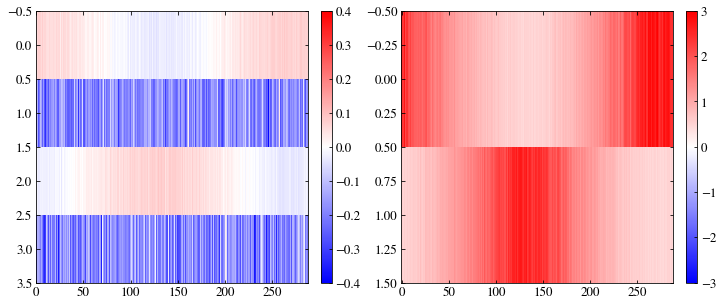

In [18]:
fig, ax = plt.subplots(1,2, figsize = (12, 5))

im0 = ax[0].imshow(model_LR2.encoder.L1.weight.data, interpolation='none', cmap='bwr', aspect=288/4,\
            **{'vmin':-0.4, 'vmax':0.4})
im1 = ax[1].imshow(model_LR2.decoder.L1.weight.data.T, interpolation='none', cmap='bwr', aspect=288/2,\
            **{'vmin':-3, 'vmax':3})

ca0 = inset_axes(ax[0], width="5%", height="100%", loc='center left',
                   bbox_to_anchor=(1.05, 0., 0.8, 1), bbox_transform=ax[0].transAxes, borderpad=0)
ca1 = inset_axes(ax[1], width="5%", height="100%", loc='center left',
                   bbox_to_anchor=(1.05, 0., 0.8, 1), bbox_transform=ax[1].transAxes, borderpad=0)
cd = plt.colorbar(im0, cax=ca0)
cd = plt.colorbar(im1, cax=ca1)

plt.savefig('fig/LR2_weight.png')

## TEST

In [72]:
modelname = 'NN100'
model = model_NN100


if model == model_LR2: latent_dim = 2
elif model == model_LR4: latent_dim = 4
else: latent_dim = 8
    
U_len = len(U_up)+len(U_dn)
spin2dtest = np.concatenate([spin2d_up_test, spin2d_dn_test])

spin2dtest = torch.Tensor(spin2dtest)
spin2d_up_test = torch.Tensor(spin2d_up_test)
spin2d_dn_test = torch.Tensor(spin2d_dn_test)
spin2d_up = torch.Tensor(spin2d_up)
spin2d_dn = torch.Tensor(spin2d_dn)

#xs, x_params, zs, z_params = model.reconstruct_img(spin2dtest)
#xs_up, x_params_up, zs_up, z_params_up = model.reconstruct_img(spin2d_up_test)
#xs_dn, x_params_dn, zs_dn, z_params_dn = model.reconstruct_img(spin2d_dn_test)
xs_tot_up, x_params_tot_up, zs_tot_up, z_params_tot_up = model.reconstruct_img(spin2d_up)
xs_tot_dn, x_params_tot_dn, zs_tot_dn, z_params_tot_dn = model.reconstruct_img(spin2d_dn)

for i,u in enumerate(U_up):
    np.savetxt(f'../3_VAE_recon/test_{modelname}/Bethe_14_beta{b:d}/field-{u:.2f}.dat', \
               xs_tot_up[i*s_num:(i+1)*s_num])
for i,u in enumerate(U_dn):
    np.savetxt(f'../3_VAE_recon/test_{modelname}/Bethe_41_beta{b:d}/field-{u:.2f}.dat', \
               xs_tot_dn[i*s_num:(i+1)*s_num])

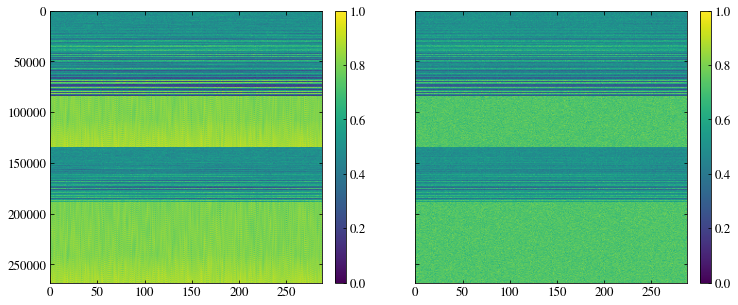

In [61]:
fig, ax = plt.subplots(1,2, figsize = (12, 5), sharey=True)
im0 = ax[0].imshow(spin2dtest.reshape(U_len*s_test, 288), aspect=0.5*spin2d.size(1)/spin2d.size(0))
ca0 = inset_axes(ax[0], width="5%", height="100%", loc='center left',\
                bbox_to_anchor=(1.05, 0., 0.8, 1), bbox_transform=ax[0].transAxes, borderpad=0)
cd = plt.colorbar(im0, cax=ca0)
im1 = ax[1].imshow(xs.reshape(U_len*s_test, 288), aspect=0.5*spin2d.size(1)/spin2d.size(0))
ca1 = inset_axes(ax[1], width="5%", height="100%", loc='center left',\
                bbox_to_anchor=(1.05, 0., 0.8, 1), bbox_transform=ax[1].transAxes, borderpad=0)
cd = plt.colorbar(im1, cax=ca1)
plt.savefig(f'fig/{modelname}_result.png')

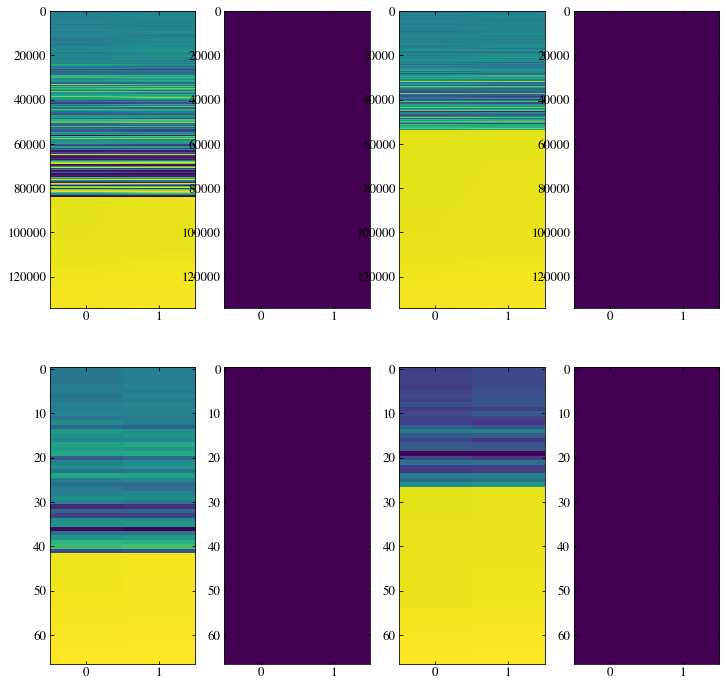

In [62]:
test_mu_up = z_params_up[:, :, 0].detach().numpy()
test_logsig_up = z_params_up[:, :, 1].detach().numpy()
test_var_up = np.exp(test_logsig_up * 2)
test_mu_dn = z_params_dn[:, :, 0].detach().numpy()
test_logsig_dn = z_params_dn[:, :, 1].detach().numpy()
test_var_dn = np.exp(test_logsig_dn * 2)

test_ens_mu_up = np.zeros((len(U_up), latent_dim))
test_ens_logsig_up = np.zeros((len(U_up), latent_dim))
test_ens_mu_dn = np.zeros((len(U_dn), latent_dim))
test_ens_logsig_dn = np.zeros((len(U_dn), latent_dim))
for i in range(len(U_up)):
    test_ens_mu_up[i] = np.average(z_params_up[i*s_test:(i+1)*s_test, :, 0].detach().numpy(), axis=0)
    test_ens_logsig_up[i] = np.average(z_params_up[i*s_test:(i+1)*s_test, :, 1].detach().numpy(), axis=0)
for i in range(len(U_dn)):
    test_ens_mu_dn[i] = np.average(z_params_dn[i*s_test:(i+1)*s_test, :, 0].detach().numpy(), axis=0)
    test_ens_logsig_dn[i] = np.average(z_params_dn[i*s_test:(i+1)*s_test, :, 1].detach().numpy(), axis=0)
test_ens_var_up = np.exp(test_ens_logsig_up * 2)
test_ens_var_dn = np.exp(test_ens_logsig_dn * 2)

test_ens_mu = np.concatenate([test_ens_mu_up, test_ens_mu_dn])
test_ens_var = np.concatenate([test_ens_var_up, test_ens_var_dn])


fig, ax = plt.subplots(2,4, figsize = (12, 12))
ax[0,0].imshow(test_mu_up, aspect = 'auto')
ax[0,1].imshow(test_var_up, aspect = 'auto')
ax[0,2].imshow(test_mu_dn, aspect = 'auto')
ax[0,3].imshow(test_var_dn, aspect = 'auto')

ax[1,0].imshow(test_ens_mu_up, aspect = 'auto')
ax[1,1].imshow(test_ens_var_up, aspect = 'auto')
ax[1,2].imshow(test_ens_mu_dn, aspect = 'auto')
ax[1,3].imshow(test_ens_var_dn, aspect = 'auto')
plt.savefig(f'fig/{modelname}_zparam.png')

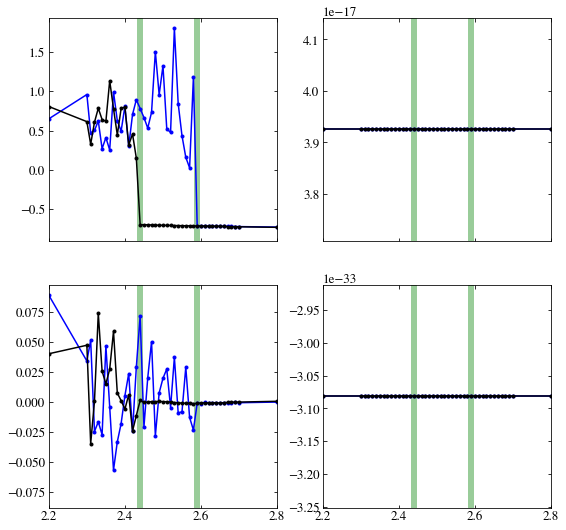

In [63]:
n = 3
if model == model_LR2: n = 2

U_c1, U_c2 = 2.44, 2.59

pca1 = PCA(n_components=n)
pca1.fit(test_ens_mu)
mu_pca_up = pca1.transform(test_ens_mu_up)
mu_pca_dn = pca1.transform(test_ens_mu_dn)

pca2 = PCA(n_components=n)
pca2.fit(test_ens_var)
var_pca_up = pca2.transform(test_ens_var_up)
var_pca_dn = pca2.transform(test_ens_var_dn)

UU = np.concatenate([U_up, U_dn])

fig, ax = plt.subplots(2,2, figsize = (9, 9), sharex=True)

ax[0,0].axvline(U_c1, c='#99cc99', lw='6')
ax[0,0].axvline(U_c2, c='#99cc99', lw='6')
ax[0,0].plot(U_up, mu_pca_up[:,0], 'b.-')
ax[0,0].plot(U_dn, mu_pca_dn[:,0], 'k.-')

ax[0,1].axvline(U_c1, c='#99cc99', lw='6')
ax[0,1].axvline(U_c2, c='#99cc99', lw='6')
ax[0,1].plot(U_up, var_pca_up[:,0], 'b.-')
ax[0,1].plot(U_dn, var_pca_dn[:,0], 'k.-')

ax[1,0].axvline(U_c1, c='#99cc99', lw='6')
ax[1,0].axvline(U_c2, c='#99cc99', lw='6')
ax[1,0].plot(U_up, mu_pca_up[:,1], 'b.-')
ax[1,0].plot(U_dn, mu_pca_dn[:,1], 'k.-')

ax[1,1].axvline(U_c1, c='#99cc99', lw='6')
ax[1,1].axvline(U_c2, c='#99cc99', lw='6')
ax[1,1].plot(U_up, var_pca_up[:,1], 'b.-')
ax[1,1].plot(U_dn, var_pca_dn[:,1], 'k.-')

ax[0,0].set_xlim(2.2, 2.8)

plt.savefig(f'fig/{modelname}_pca.png')